In [5]:
# Chargement des données d'imagerie (BreastMNIST)
from medmnist.dataset import BreastMNIST
from medmnist import INFO
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_breast_cancer
import numpy as np

# Charger BreastMNIST (images 28x28 grayscale)
data_flag = 'breastmnist'
info = INFO[data_flag]
DataClass = getattr(__import__('medmnist.dataset', fromlist=[info['python_class']]), info['python_class'])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

image_dataset = DataClass(split='train', transform=transform, download=True)


# Chargement des données tabulaires (Breast Cancer sklearn)
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
X_tab = data['data'].astype(np.float32)
y_tab = data['target'].astype(np.float32)

# Normalisation
scaler = StandardScaler()
X_tab = scaler.fit_transform(X_tab).astype(np.float32)


# Dataset multimodal simulé
class SimulatedMultimodalDataset(Dataset):
    def __init__(self, image_dataset, tabular_features, labels):
        self.image_dataset = image_dataset
        self.tabular_features = tabular_features
        self.labels = labels

    def __len__(self):
        return min(len(self.image_dataset), len(self.tabular_features))

    def __getitem__(self, idx):
        image, _ = self.image_dataset[idx]
        tabular = torch.tensor(self.tabular_features[idx])
        label = torch.tensor([self.labels[idx]])
        return image, tabular, label


#  Création du Dataset et DataLoader
from torch.utils.data import random_split

# S'assurer qu'on a la même taille
N = min(len(image_dataset), len(X_tab))
multimodal_dataset = SimulatedMultimodalDataset(
    image_dataset=image_dataset,
    tabular_features=X_tab[:N],
    labels=y_tab[:N]
)

# Split 80% train / 20% val
train_size = int(0.8 * N)
val_size = N - train_size
train_ds, val_ds = random_split(multimodal_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)





In [7]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)
print("sys.path[0] =", sys.path[0])

sys.path[0] = c:\Users\sarah\Documents\projects\python\breast_cancer_detection


In [8]:
# Boucle d'entraînement multimodale
from src.multimodal_model import MultimodalNet
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

model = MultimodalNet(tabular_input_dim=X_tab.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, tabulars, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
            images = images.to(device)
            tabulars = tabulars.to(device).float()
            labels = labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            outputs = model(images, tabulars)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, tabulars, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Val"):
                images = images.to(device)
                tabulars = tabulars.to(device).float()
                labels = labels.to(device).float().view(-1, 1)

                outputs = model(images, tabulars)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader.dataset):.4f} | Val Loss: {val_loss/len(val_loader.dataset):.4f} | Val Acc: {correct/total:.4f}")

# Lancement de l'entraînement
train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=5)

c:\Users\sarah\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sarah\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5 - Val: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Epoch 1 | Train Loss: 0.7440 | Val Loss: 0.6867 | Val Acc: 0.6909


Epoch 2/5 - Val: 100%|██████████| 2/2 [00:07<00:00,  3.50s/it]


Epoch 2 | Train Loss: 0.6578 | Val Loss: 0.6425 | Val Acc: 0.5818


Epoch 3/5 - Val: 100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Epoch 3 | Train Loss: 0.5420 | Val Loss: 0.6144 | Val Acc: 0.6455


Epoch 4/5 - Val: 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


Epoch 4 | Train Loss: 0.4317 | Val Loss: 0.7379 | Val Acc: 0.5909


Epoch 5/5 - Val: 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]

Epoch 5 | Train Loss: 0.3399 | Val Loss: 0.7777 | Val Acc: 0.7273


Accuracy : 0.7273
AUC-ROC  : 0.7466

Classification Report :
              precision    recall  f1-score   support

         0.0     0.7105    0.5870    0.6429        46
         1.0     0.7361    0.8281    0.7794        64

    accuracy                         0.7273       110
   macro avg     0.7233    0.7075    0.7111       110
weighted avg     0.7254    0.7273    0.7223       110



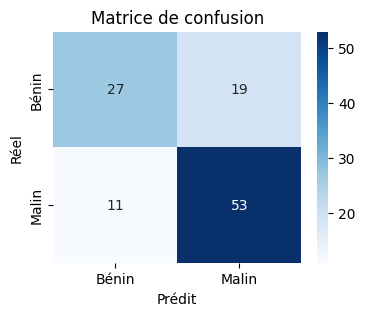

In [9]:
# 🔢 Étape 1 : Évaluation sur le test set (ici val_loader)

import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Passer le modèle en mode éval
model.eval()

y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for images, tabulars, labels in val_loader:
        images   = images.to(device)
        tabulars = tabulars.to(device).float()
        labels   = labels.to(device).float().view(-1,1)

        outputs = model(images, tabulars)

        # Collecte des ground-truth et prédictions
        y_true.extend(labels.cpu().numpy().ravel())
        y_prob.extend(outputs.cpu().numpy().ravel())
        y_pred.extend((outputs > 0.5).float().cpu().numpy().ravel())

# Conversion en array 1-D
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# 1) Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy : {acc:.4f}")

# 2) AUC-ROC
auc = roc_auc_score(y_true, y_prob)
print(f"AUC-ROC  : {auc:.4f}")

# 3) Classification report
print("\nClassification Report :")
print(classification_report(y_true, y_pred, digits=4))

# 4) Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bénin','Malin'],
            yticklabels=['Bénin','Malin'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()


In [14]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)
print("sys.path[0] =", sys.path[0])
# Sauvegarde
torch.save(model.state_dict(), 'C:/Users/sarah/Documents/projects/python/breast_cancer_detection/models/multimodal_model.pt')
print("Modèle multimodal sauvé dans models/multimodal_model.pt")


sys.path[0] = c:\Users\sarah\Documents\projects\python\breast_cancer_detection
Modèle multimodal sauvé dans models/multimodal_model.pt
